# Project 1, Part 4, Holiday Analytics

University of California, Berkeley
Master of Information and Data Science (MIDS) program
w205 - Fundamentals of Data Engineering

Student: Stephanie Cabanela

Year: 2022

Semester: Spring

Section: 7


# Included Modules and Packages

Code cell containing your includes for modules and packages

In [1]:
import math
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import datetime

# Supporting code

Code cells containing any supporting code, such as connecting to the database, any functions, etc.  Remember you can use any code from the labs.

In [2]:
# Source for this cell: Lab 2

#
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

# Connect to Postgres database
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

# Create a cursor for the connection
cursor = connection.cursor()

## How do holidays affect the sales, considering both the actual holiday, and the days before and after the holiday? 

## Create an executive summary explaining how holidays have affected sales. 

## You must support your summary with data, in the form of output of queries, data visualization, etc. There is a 1 query minimum.

# Exploratory Data Analysis (EDA)

## What year is our data in?

In [3]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select sale_date
from sales
order by sale_date desc
limit 10

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,sale_date
0,2020-12-31
1,2020-12-31
2,2020-12-31
3,2020-12-31
4,2020-12-31
5,2020-12-31
6,2020-12-31
7,2020-12-31
8,2020-12-31
9,2020-12-31


# Get average sales per day of week

In [4]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select extract(dow from sale_date) as day_number,
        to_char(sale_date, 'Day') as day_name,
        avg(total_amount) as expected_sales
from sales
group by day_number, day_name
order by day_number

"""


my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,day_number,day_name,expected_sales
0,0,Sunday,64.129203
1,1,Monday,64.261306
2,2,Tuesday,64.149784
3,3,Wednesday,64.212271
4,4,Thursday,64.356461
5,5,Friday,64.060346
6,6,Saturday,64.297760


# Get actual vs expected for all days in 2020

In [5]:
rollback_before_flag = True
rollback_after_flag = True

query = """
select everyday.sale_date,
        everyday.day_name,
        everyday.actual_sales as actual,
        expected.expected_sales as expected,
        (everyday.actual_sales/expected.expected_sales)-1 as difference,
        round(abs((everyday.actual_sales/expected.expected_sales)-1), 5) as absolute
from
        (select sale_date, 
                to_char(sale_date, 'Day') as day_name,
                avg(total_amount) as actual_sales
        from sales
        group by sale_date
        order by sale_date) as everyday
    join
        (select extract(dow from sale_date) as day_number,
                to_char(sale_date, 'Day') as day_name,
                avg(total_amount) as expected_sales
        from sales
        group by day_number, day_name
        order by day_number) as expected
    on everyday.day_name = expected.day_name
order by absolute desc

"""

df_difference = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df_difference

,sale_date,day_name,actual,expected,difference,absolute
0,2020-06-02,Tuesday,66.495413,64.149784,3.656487e-02,0.03656
1,2020-01-17,Friday,61.755102,64.060346,-3.598551e-02,0.03599
2,2020-04-21,Tuesday,66.293666,64.149784,3.341994e-02,0.03342
3,2020-09-16,Wednesday,66.098503,64.212271,2.937494e-02,0.02937
4,2020-04-12,Sunday,66.002908,64.129203,2.921766e-02,0.02922
...,...,...,...,...,...,...
359,2020-07-19,Sunday,64.123136,64.129203,-9.460696e-05,0.00009
360,2020-03-18,Wednesday,64.206880,64.212271,-8.396440e-05,0.00008
361,2020-07-26,Sunday,64.132540,64.129203,5.202963e-05,0.00005
362,2020-01-24,Friday,64.058182,64.060346,-3.379129e-05,0.00003


# Which dates deviated the most from the expected average?

In [30]:
rollback_before_flag = True
rollback_after_flag = True

query = """
select *
from (select everyday.sale_date,
        everyday.day_name,
        everyday.actual_sales as actual,
        expected.expected_sales as expected,
        (everyday.actual_sales/expected.expected_sales)-1 as difference,
        round(abs((everyday.actual_sales/expected.expected_sales)-1), 5) as absolute
from
        (select sale_date, 
                to_char(sale_date, 'Day') as day_name,
                avg(total_amount) as actual_sales
        from sales
        group by sale_date
        order by sale_date) as everyday
    join
        (select extract(dow from sale_date) as day_number,
                to_char(sale_date, 'Day') as day_name,
                avg(total_amount) as expected_sales
        from sales
        group by day_number, day_name
        order by day_number) as expected
    on everyday.day_name = expected.day_name) as temp
where absolute >= 0.02
order by difference desc

"""

df_difference = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df_difference

,sale_date,day_name,actual,expected,difference,absolute
0,2020-06-02,Tuesday,66.495413,64.149784,0.036565,0.03656
1,2020-04-21,Tuesday,66.293666,64.149784,0.033420,0.03342
2,2020-09-16,Wednesday,66.098503,64.212271,0.029375,0.02937
3,2020-04-12,Sunday,66.002908,64.129203,0.029218,0.02922
4,2020-08-17,Monday,65.916023,64.261306,0.025750,0.02575
5,2020-02-17,Monday,65.900585,64.261306,0.025510,0.02551
6,2020-03-31,Tuesday,65.653846,64.149784,0.023446,0.02345
7,2020-09-20,Sunday,65.620723,64.129203,0.023258,0.02326
8,2020-06-09,Tuesday,62.841953,64.149784,-0.020387,0.02039
9,2020-01-02,Thursday,63.011583,64.356461,-0.020897,0.02090


# Get list of holidays

In [6]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select *
from holidays

"""

df_holidays = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df_holidays

,holiday_date,description,closed_flag
0,2020-01-01,New Year's Day,False
1,2020-01-20,MLK Day,False
2,2020-02-17,President's Day,False
3,2020-04-12,Easter,False
4,2020-05-10,Mother's Day,False
5,2020-05-25,Memorial Day,False
6,2020-06-21,Father's Day,False
7,2020-07-04,Independence Day,False
8,2020-09-07,Labor Day,False
9,2020-11-11,Veterans Days,False


# Plot expected vs. actual averages for each holiday window

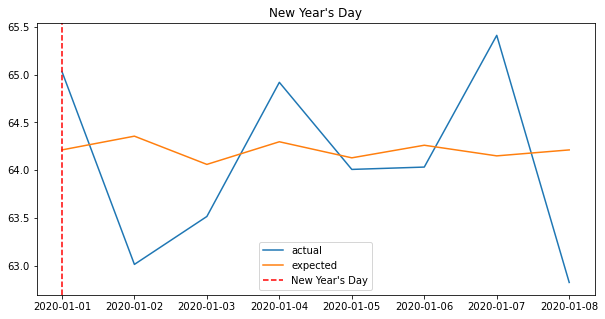

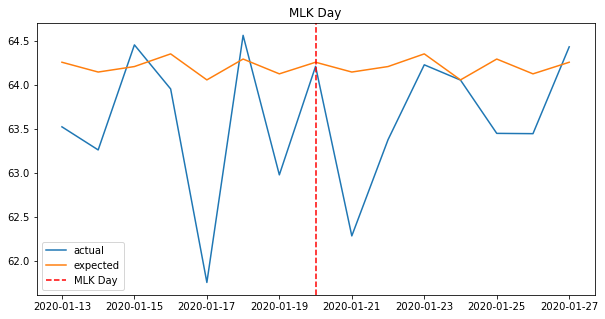

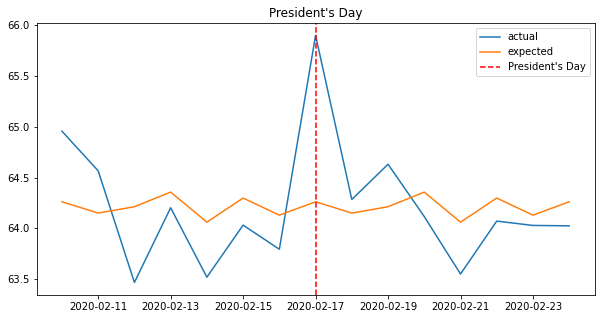

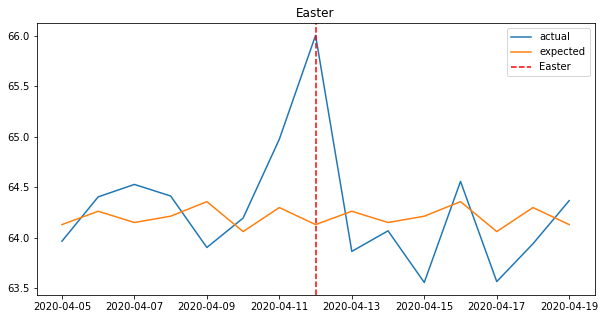

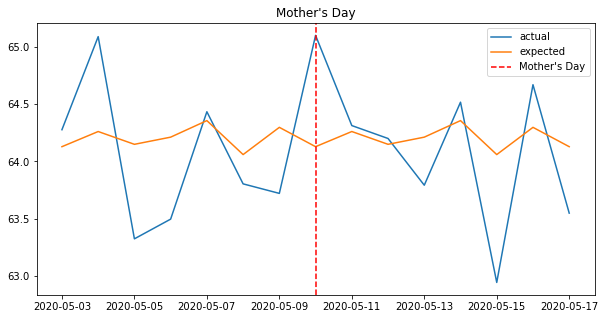

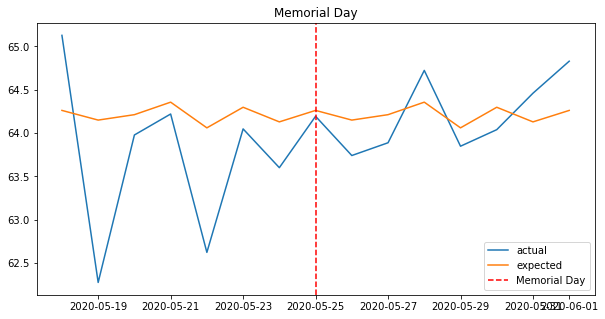

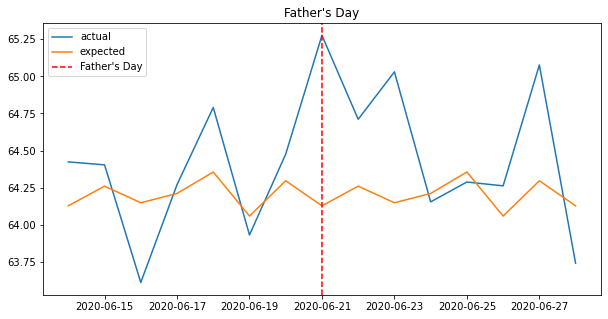

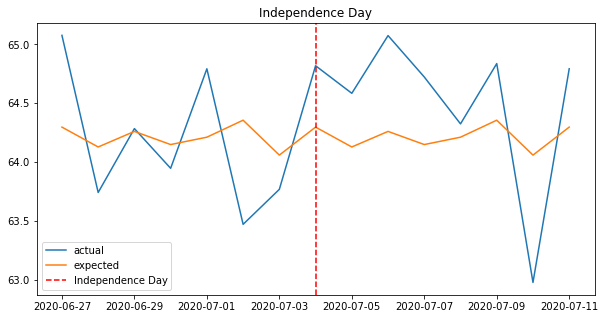

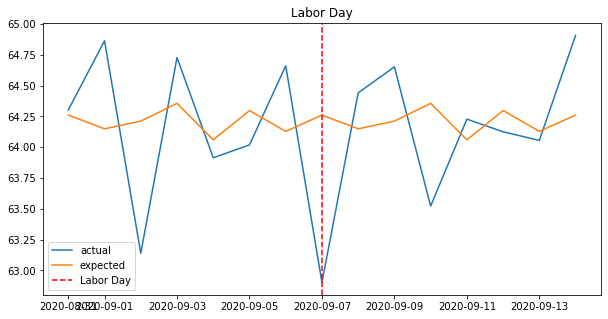

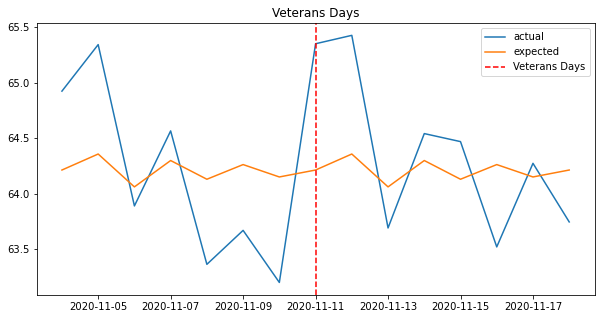

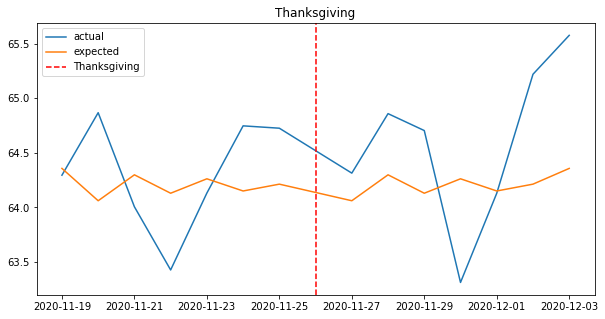

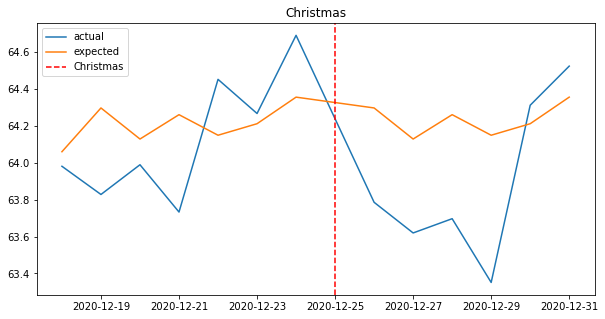

In [24]:
df_holiday_diff = df_difference.copy()
df_holiday_diff['sale_date']=pd.to_datetime(df_holiday_diff['sale_date']).dt.date
df_holiday_diff.set_index('sale_date', inplace = True)

holiday_dates = df_holidays['holiday_date'].tolist()
holiday_descriptions = df_holidays['description'].tolist()

appended_stuff = []
for i in range(12):
    holiday_date = df_holidays['holiday_date'][i]
    holiday_description = df_holidays['description'][i]

    # START DATE
    start_date = holiday_date + datetime.timedelta(days=-7)
    if start_date.year < 2020:
        start_date = datetime.datetime(2020,1,1)
    start_date = datetime.date(start_date.year, start_date.month, start_date.day)

    # END DATE
    end_date  = holiday_date + datetime.timedelta(days=+7)
    if end_date.year > 2020:
        end_date = datetime.datetime(2020,12,31)
    end_date = datetime.date(end_date.year, end_date.month, end_date.day)

    new_df = df_holiday_diff[(df_holiday_diff.index >= start_date) & (df_holiday_diff.index <= end_date)]
    new_df.insert(0, 'closest_holiday', holiday_description)
    appended_stuff.append(new_df)

results = pd.concat(appended_stuff)

# REMOVE DUPLICATES
# results = results[~results.index.duplicated(keep='first')]

results = results.sort_index()

# PLOT EACH HOLIDAY
for holiday_index in range(12):
    results_plot_df = results[results['closest_holiday'] == holiday_descriptions[holiday_index]]
    plt.figure(figsize=(10,5))
    plt.plot(results_plot_df.index.values, results_plot_df['actual'], label='actual')
    plt.plot(results_plot_df.index.values, results_plot_df['expected'], label='expected')
    plt.title(holiday_descriptions[holiday_index])
    # plt.xlabel('Month')
    # plt.ylabel('Sales (Millions of Dollars)')
    # plt.ylim(bottom=6, top=10)
#         holiday_sales = df.loc[df.sale_date == holiday_date,'total_sales_per_day'].values[0]
#         plt.plot(holiday_date,holiday_sales,'ro')
    plt.axvline(x=df_holidays['holiday_date'][holiday_index], label=holiday_descriptions[holiday_index], color='r', linestyle='--')
    plt.legend()
plt.show()

# print(results[results['closest_holiday'] == holiday_descriptions[holiday_index]]['closest_holiday'].size)
# results[results['closest_holiday'] == holiday_descriptions[holiday_index]]
